In [1]:
import deepsurvk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk

from sksurv.metrics import (
    concordance_index_ipcw,
    concordance_index_censored,
    brier_score,
    cumulative_dynamic_auc
)

C:\Users\harri\anaconda3\envs\deepsurv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization,Activation,BatchNormalization,Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback
tf.random.set_seed(108)

In [3]:
train = pd.read_csv("train2.csv",index_col = 0)
#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)



y = train[["event_observed","event_max",'death_in_study']]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)
test = pd.read_csv("test2.csv",index_col = 0)

X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columyns=X_test.columns,index=test.index)

y_test = test[["event_observed","event_max",'death_in_study']]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [4]:
from lifelines import KaplanMeierFitter
# Create a censoring indicator (1 = censored, 0 = event)
data = pd.concat([X_train,y],axis=1)


data['censoring_indicator'] = 1 - data['event_observed']

# Fit the Kaplan-Meier model to censoring data
kmf_censor = KaplanMeierFitter()

# Fit the model where time is the follow-up time and censoring_indicator denotes censoring
kmf_censor.fit(durations=data['event_max'], event_observed=data['censoring_indicator'])

# Predict the survival probability of being uncensored (censoring probability)
data['S_c'] = kmf_censor.survival_function_at_times(data['event_max']).values
data['ipcw'] = 1 / (data['S_c']+1e-3)

In [6]:
from lifelines import CoxPHFitter

# Define a Cox model for censoring (using covariates if available)
censoring_model = CoxPHFitter()
censoring_data = data.drop(['death_in_study','S_c','ipcw','event_observed'],axis=1)
censoring_model.fit(censoring_data, duration_col='event_max', event_col='censoring_indicator')

censoring_model.print_summary()
# Predict censoring probabilities
data['S_cox'] = censoring_model.predict_survival_function(censoring_data).iloc[-1]
data['ipcw_cox'] = 1 / (data['S_cox'] + 1e-3)

<lifelines.CoxPHFitter: fitted with 7194 total observations, 692 right-censored observations>
             duration col = 'event_max'
                event col = 'censoring_indicator'
      baseline estimation = breslow
   number of observations = 7194
number of events observed = 6502
   partial log-likelihood = -50705.94
         time fit was run = 2024-09-24 05:05:56 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
gender_2.0                   -0.02       0.98       0.04            -0.10             0.05                 0.90                 1.06
cad_1.0                       0.01       1.01       0.03            -0.05             0.07                 0.95                 1.07
prior_acute_mi_1.0           -0.00       1.00       0.04            -0.08             0.08                 0.92                 1.08
prior_cardio_surg_1.0        -0.03       0.97       0.07            -0.17             0.11                 0.85                 1.12
prior_pci_1.0                 0.05       1.05       0.03            -0.02             0.11                 0.98                 1.12
prior_cabg_1.0               -0.03       0.97       0.07            -0.17             0.12                 0.84                 1.12
prior_valve_replace_1.0       0.02       1.02       0.16            -0.29             0.33                 0.75                 1.40
prior_bav_1.0                -0.12       0.89       0.05            -0.22            -0.02                 0.81                 0.98
prior_af_1.0                 -0.02       0.98       0.04            -0.09             0.06                 0.92                 1.06
prior_generator_1.0           0.02       1.02       0.06            -0.09             0.13                 0.91                 1.14
prior_ccf_1.0                -0.06       0.94       0.03            -0.12             0.00                 0.89                 1.00
prior_stroke_1.0              0.01       1.01       0.05            -0.08             0.11                 0.92                 1.11
prior_tia_1.0                -0.01       0.99       0.05            -0.10             0.09                 0.90                 1.09
prior_carotid_sten_2.0        0.04       1.04       0.09            -0.14             0.22                 0.87                 1.25
prior_carotid_sten_3.0       -0.03       0.97       0.09            -0.21             0.14                 0.81                 1.16
prior_carotid_sten_4.0       -0.13       0.88       0.05            -0.23            -0.02                 0.79                 0.98
prior_carotid_sten_5.0       -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
prior_pad_1.0                -0.01       0.99       0.04            -0.08             0.07                 0.92                 1.07
chronic_lung_2.0             -0.02       0.98       0.03            -0.09             0.05                 0.92                 1.05
chronic_lung_3.0             -0.04       0.96       0.04            -0.13             0.05                 0.88                 1.05
chronic_lung_4.0             -0.22       0.80       0.07            -0.36            -0.09                 0.70                 0.92
hypertension_1.0              0.02       1.02       0.03            -0.04             0.08                 0.96                 1.09
diabetes_1.0                 -0.02       0.98       0.03            -0.08             0.03                 0.92                 1.03
ckd_1.0                      -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
dialysis_1.0                 -0.13       0.88       0.13            -0.38             0.13                 0.68                 1.14
meds_ACE_ARB_1.0            

<Axes: xlabel='S_cox', ylabel='Density'>

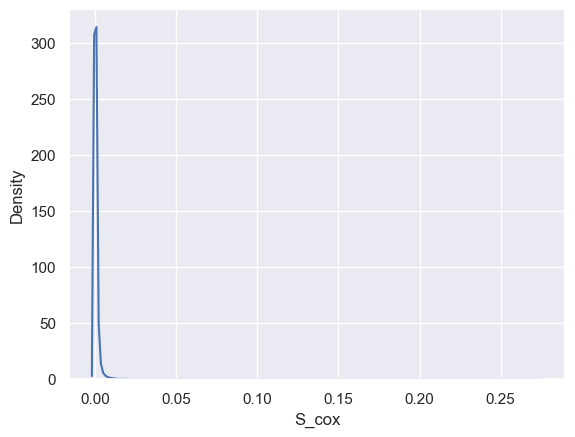

In [9]:
sns.kdeplot(data['S_cox'])
sns.kdeplot(data['S_c'])

In [11]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(y_train['death_in_study']),
                                            y = y_train['death_in_study'])
class_weights_dict = dict(zip(np.unique(y_train['death_in_study']).astype(int), class_weights))

In [15]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler


X_scaler = StandardScaler().fit(X_train)
X_train_scale = X_scaler.transform(X_train)

Y_scaler = StandardScaler().fit(y_train["event_max"].reshape(-1, 1))
y_train_scale = Y_scaler.transform(y_train["event_max"].reshape(-1, 1))
y_train_scale = y_train_scale.flatten()
#y_train_scale = y_train["event_max"].flatten()

y_test_scale = Y_scaler.transform(y_test["event_max"].reshape(-1, 1))
y_test_scale = y_test_scale.flatten()
#y_test_scale = y_test["event_max"].flatten()

In [16]:
sort_idx = np.argsort(y_train["event_max"], axis=0)[::-1]
X_train_scale = X_train_scale[sort_idx, :]
y_train_scale = y_train_scale[sort_idx]
y_train_sort = y_train["event_max"][sort_idx].reshape(-1, 1)
E_train = y_train["death_in_study"][sort_idx]

ipcw_weights = np.array(data["ipcw"])[sort_idx]
death_train = y_train["death_in_study"][sort_idx].astype(float)

In [17]:
n_features = X_train.shape[1]
n_batch = X_train.shape[0]

In [70]:
activation = 'relu'
n_nodes = 48
learning_rate = 0.01
l2_reg = 20
dropout = 0.12
lr_decay =  6.494e-4
momentum = 0.2
output_bias_init = np.log(sum(death_train)/(len(death_train) - sum(death_train)))

In [71]:
# Custom scaled tanh activation function
def scaled_tanh(x):
    return 7 * tf.tanh(x)  # Scale tanh output to range [-10, 10]

In [79]:
def negative_log_likelihood(E):
    def loss(y_true, y_pred):
        
        hazard_ratio = tf.math.exp(y_pred)        
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood =  uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)

        # TODO
        # For some reason, adding num_observed_events does not work.
        # Therefore, for now we will use it as a simple factor of 1.
        # Is it really needed? Isn't it just a scaling factor?
        # num_observed_events = tf.math.cumsum(E)
        # num_observed_events = tf.cast(num_observed_events, dtype=tf.float32)
        #num_observed_events = tf.constant(1, dtype=tf.float32)
        num_observed_events = tf.math.reduce_sum(E)
        #weight_sum = tf.math.reduce_sum(weights)
        
        neg_likelihood = neg_likelihood_ / (num_observed_events)
        
        #output_reg = tf.math.reduce_mean(tf.math.square(y_pred))  # Penalize large output magnitudes
        #reg_weight = 1000
        penalty_threshold = -3
        penalty = tf.math.reduce_mean(tf.math.square(tf.math.maximum(penalty_threshold - y_pred , 0.0)))
        penalty_weight = 10  # Adjust weight
        
         # Define the desired range for the output
        #min_val = -.0  # minimum acceptable value
        #max_val = 5.0   # maximum acceptable value

        # Penalty for predictions outside the range (either too low or too high)
        #lower_penalty = tf.math.maximum(min_val - y_pred, 0.0)  # penalty for being below min_val
        #upper_penalty = tf.math.maximum(y_pred - max_val, 0.0)  # penalty for being above max_val

        # Combine penalties
        #penalty = tf.math.reduce_mean(tf.math.square(lower_penalty) + tf.math.square(upper_penalty))

        # Apply a scaling factor to the penalty to adjust its impact
        #penalty_weight = 0.01  # Adjust this to control the strength of the penalty
        total_loss = neg_likelihood + penalty_weight * penalty
        
        
        
        return neg_likelihood
    
    return loss

In [80]:
def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        b_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return tf.math.reduce_mean(weighted_b_ce)
    
    return loss

In [81]:
# Create model
model = Sequential()

model.add(Dense(units=n_features, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform',kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=1, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg),activation='linear'
               ))
#model.add(Activation(activations.selu))
model.add(ActivityRegularization(l2=l2_reg))
#lambda x: activations.selu(x,alpha=0.2))

# Define the optimizer
# Nadam is Adam + Nesterov momentum
# optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay, clipnorm=1) 
optimizer = Nadam(learning_rate=learning_rate, weight_decay=lr_decay)

# Compile the model and show a summary of it
model.compile(loss=negative_log_likelihood(np.float32(E_train)), optimizer=optimizer)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 99)                9900      
                                                                 
 dropout_15 (Dropout)        (None, 99)                0         
                                                                 
 dense_21 (Dense)            (None, 48)                4800      
                                                                 
 dropout_16 (Dropout)        (None, 48)                0         
                                                                 
 dense_22 (Dense)            (None, 48)                2352      
                                                                 
 batch_normalization_5 (Bat  (None, 48)                192       
 chNormalization)                                                
                                                      

In [82]:
callbacks = [tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.EarlyStopping(monitor='loss',patience=20,start_from_epoch=40,verbose=1)]
             #tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
             # Instantiate the callback with the model
               #GradientMonitor(model, log_frequency=10)]
             #tf.keras.callbacks.ModelCheckpoint(str(PATH_MODELS/f'{example_file}.h5'), monitor='loss', save_best_only=True, mode='min')]

In [83]:
epochs = 500

history = model.fit(X_train_scale, y_train_scale,
                    batch_size=n_batch, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 68853.6016
Epoch 2/500
1/1 [==============================] - 0s 93ms/step - loss: 63139.7461
Epoch 3/500
1/1 [==============================] - 0s 91ms/step - loss: 61178.7773
Epoch 4/500
1/1 [==============================] - 0s 101ms/step - loss: 59126.6758
Epoch 5/500
1/1 [==============================] - 0s 102ms/step - loss: 59035.8047
Epoch 6/500
1/1 [==============================] - 0s 106ms/step - loss: 58358.0859
Epoch 7/500
1/1 [==============================] - 0s 101ms/step - loss: 57681.1836
Epoch 8/500
1/1 [==============================] - 0s 108ms/step - loss: 57003.6211
Epoch 9/500
1/1 [==============================] - 0s 101ms/step - loss: 56503.4141
Epoch 10/500
1/1 [==============================] - 0s 104ms/step - loss: 56190.3984
Epoch 11/500
1/1 [==============================] - 0s 102ms/step - loss: 55669.1719
Epoch 12/500
1/1 [==============================] - 0s 105ms/step - loss: 55330

1/1 [==============================] - 0s 98ms/step - loss: 40312.2383
Epoch 99/500
1/1 [==============================] - 0s 93ms/step - loss: 39285.9180
Epoch 100/500
1/1 [==============================] - 0s 98ms/step - loss: 37964.6719
Epoch 101/500
1/1 [==============================] - 0s 97ms/step - loss: 38794.5195
Epoch 102/500
1/1 [==============================] - 0s 91ms/step - loss: 37426.6914
Epoch 103/500
1/1 [==============================] - 0s 93ms/step - loss: 37296.9141
Epoch 104/500
1/1 [==============================] - 0s 94ms/step - loss: 36568.9414
Epoch 105/500
1/1 [==============================] - 0s 87ms/step - loss: 35872.5156
Epoch 106/500
1/1 [==============================] - 0s 99ms/step - loss: 35623.6484
Epoch 107/500
1/1 [==============================] - 0s 98ms/step - loss: 36378.8047
Epoch 108/500
1/1 [==============================] - 0s 91ms/step - loss: 35803.3711
Epoch 109/500
1/1 [==============================] - 0s 92ms/step - loss: 34584.

from sklearn.preprocessing import StandardScaler


whasX_train, whasY_train, whasE_train, = load_whas(partition='training', data_type='np')
X_scaler = StandardScaler().fit(whasX_train)
whasX_train = X_scaler.transform(whasX_train)

Y_scaler = StandardScaler().fit(whasY_train.reshape(-1, 1))
whasY_train = Y_scaler.transform(whasY_train)
whasY_train = whasY_train.flatten()


Text(0, 0.5, 'Loss [u.a.]')

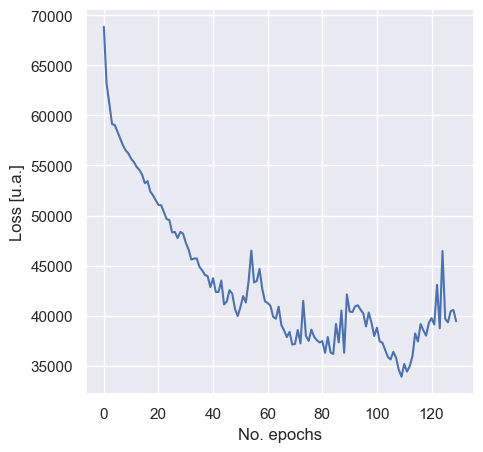

In [84]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plt.plot(history.history['loss'], label='train')
ax.set_xlabel("No. epochs")
ax.set_ylabel("Loss [u.a.]")

In [85]:
X_test_scale = X_scaler.transform(X_test)
y_predict = np.exp(-model.predict(X_test_scale))
#y_predict = model.predict(X_test_scale)
y_predict_train = np.exp(-model.predict(X_train_scale))
#y_predict_train = model.predict(X_train_scale)
#y_predict_death = model.predict(X_test_scale)[1]>0.5

from lifelines.utils import concordance_index

#print(concordance_index_ipcw(y_train,y_test,y_predict.flatten(),tau=365))
#print(concordance_index_ipcw(y_train,y_train,y_predict_train.flatten(),tau=365))

print(concordance_index(y_train_scale, y_predict_train, E_train))
print(concordance_index(y_test_scale, y_predict, y_test["event_observed"]))

from sklearn.metrics import accuracy_score
#print(sum(y_predict_death))
#print(accuracy_score(y_test["death_observed"],y_predict_death))
#concordance_index_ipcw(y_train,y_test,Y_scaler.inverse_transform(y_predict).flatten(),tau=365)

225/225 [==============================] - 0s 790us/step
0.9420854802141566
0.6430844243220567


In [86]:
sum(y_predict<365)/len(y_predict)

array([0.9922179])

In [87]:
y_predict

array([[ 4.131458  ],
       [34.9356    ],
       [ 0.131544  ],
       ...,
       [ 0.3271696 ],
       [ 0.78673345],
       [26.065163  ]], dtype=float32)

In [88]:
print(min(y_predict))
#min(Y_scaler.inverse_transform(y_predict))
max(-np.log(y_predict))



[0.00416106]


array([5.4819856], dtype=float32)

In [89]:
print(max(y_predict))
min(-np.log(y_predict))
#max(Y_scaler.inverse_transform(y_predict))


[66990.02]


array([-11.112299], dtype=float32)

In [90]:
max(model.predict(X_train_scale)[0])

225/225 [==============================] - 0s 767us/step


-0.07414329

225/225 [==============================] - 0s 786us/step


<Axes: ylabel='Density'>

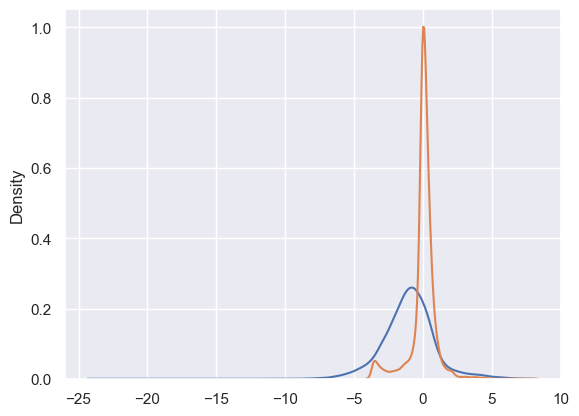

In [91]:
sns.kdeplot(x=model.predict(X_train_scale)[:,0])
sns.kdeplot(x=y_train_scale)

In [ ]:
sns.kdeplot(x=np.clip(np.exp(-model.predict(X_train_scale)[:,0]),a_max=2,a_min=0))
sns.kdeplot(x=y_train_scale)

In [ ]:
#sns.kdeplot(x=y_test_scale)
sns.kdeplot(x=model.predict(X_test_scale)[:,0])
sns.kdeplot(x=y_test_scale)

In [ ]:
sns.kdeplot(x=np.exp(-y_predict)[:,0])
sns.kdeplot(x=np.exp(-y_test_scale))

In [ ]:
Y_scaler.inverse_transform(y_predict)[:,0]

In [ ]:
from deepsurvk.datasets import load_whas

In [ ]:
X_train, Y_train, E_train, = load_whas(partition='training', data_type='np')
X_test, Y_test, E_test = load_whas(partition='testing', data_type='np')

In [ ]:
sns.kdeplot(x=np.exp(-y_test_scale))

In [ ]:
sns.kdeplot(x=y_train["event_max"])

In [ ]:
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Y_scaler = StandardScaler().fit(Y_train.reshape(-1, 1))
Y_train = Y_scaler.transform(Y_train)
Y_test = Y_scaler.transform(Y_test)

In [ ]:
Y_test

In [ ]:
Y_scaler.mean_

In [ ]:
y_predict.reshape((-1,1))